## Imports

In [71]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv('data_cleaned.csv', parse_dates=['date'])

## Time Series Creation Functions

In [3]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'profit':'net_profit'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [4]:
def create_ts_dt_feat(ts_df):
    ts_df['year'] = ts_df['date'].dt.year
    ts_df['month'] = ts_df['date'].dt.month
    ts_df['day'] = ts_df['date'].dt.day
    ts_df['weekofyear'] = ts_df['date'].dt.week
    ts_df['weekday'] = ts_df['date'].dt.weekday
    ts_df['weekday'] = np.where(ts_df.weekday == 0, 7, ts_df.weekday)
    return ts_df

In [5]:
def create_ts_lag_feat(ts_df, start, n_lag):
    for lag in range(start, n_lag+1):
        ts_df[f'lag_{lag}'] = ts_df.iloc[:, 1].shift(lag)
    ts_df = ts_df.iloc[n_lag: , :]
    return ts_df

In [6]:
def create_month_revenue_plot_per_cat(df, coltype, catlist):
    df_list = []
    for cat in catlist:
        tmp = df[df[coltype] == cat]
        tmp = select_series(tmp, 'month', 'net')
        tmp[coltype] = cat
        df_list.append(tmp)
    final_df = pd.concat(df_list).reset_index()
    sns.lineplot(data=final_df, x="date", y="net_revenue", hue=f"{coltype}")
    return final_df

## Data Prep and Feature Engineering

In [75]:
df=select_series(df, 'day', 'net')

In [11]:
lstm_df = df.copy()
lstm_df['prev_revenue'] = lstm_df['net_revenue'].shift(1)
lstm_df = lstm_df.dropna()
lstm_df['difference'] = (lstm_df['net_revenue'] - lstm_df['prev_revenue'])

In [12]:
lstm_df.head()

,date,net_revenue,prev_revenue,difference
1,2019-06-02,48.754263,4062.616362,-4013.862099
2,2019-06-03,1307.299902,48.754263,1258.545638
3,2019-06-04,70505.743012,1307.299902,69198.443110
4,2019-06-05,66236.436269,70505.743012,-4269.306742
5,2019-06-06,18990.873014,66236.436269,-47245.563256


In [13]:
lstm_df = create_ts_lag_feat(lstm_df, 1, 90)

In [17]:
lstm_df.drop('prev_revenue', axis=1,inplace=True)

In [18]:
lstm_df.head()

,date,net_revenue,difference,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90
91,2019-08-31,42765.974625,-6644.167796,49410.142421,58103.319570,49296.797909,51032.919895,51431.152471,44649.223093,29972.616805,...,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012,1307.299902,48.754263
92,2019-09-01,64333.412094,21567.437470,42765.974625,49410.142421,58103.319570,49296.797909,51032.919895,51431.152471,44649.223093,...,6347.609510,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012,1307.299902
93,2019-09-02,78554.275756,14220.863662,64333.412094,42765.974625,49410.142421,58103.319570,49296.797909,51032.919895,51431.152471,...,31028.996189,6347.609510,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012
94,2019-09-03,64570.286523,-13983.989233,78554.275756,64333.412094,42765.974625,49410.142421,58103.319570,49296.797909,51032.919895,...,11830.319282,31028.996189,6347.609510,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269
95,2019-09-04,58416.676703,-6153.609821,64570.286523,78554.275756,64333.412094,42765.974625,49410.142421,58103.319570,49296.797909,...,130.669767,11830.319282,31028.996189,6347.609510,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014


In [22]:
# Define the regression formula
m = smf.ols(formula='difference ~ lag_1', data=lstm_df)
# Fit the regression
m_fit = m.fit()
# Extract the adjusted r-squared
regression_adj_rsq = m_fit.rsquared_adj
print(regression_adj_rsq)

0.050594651744021446


In [24]:
# Define the regression formula
m = smf.ols(formula='difference ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+lag_13', data=lstm_df)
# Fit the regression
m_fit = m.fit()
# Extract the adjusted r-squared
regression_adj_rsq = m_fit.rsquared_adj
print(regression_adj_rsq)

0.22601604199270575


In [30]:
train = lstm_df[lstm_df['date'] < pd.Timestamp('2021-06-01')].drop(['net_revenue','date'],axis=1).values
test = lstm_df[lstm_df['date'] >= pd.Timestamp('2021-06-01')].drop(['net_revenue','date'],axis=1).values

In [31]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

# reshape training set
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)
# reshape test set
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)

In [32]:
test_scaled

array([[-0.09128258, -0.03164758, -0.04658943, ..., -0.17338234,
        -0.08778537,  0.19787621],
       [ 0.02086457, -0.19227311, -0.03164758, ..., -0.12764181,
        -0.17338234, -0.08778537],
       [ 0.04234567, -0.23501979, -0.19227311, ...,  0.10580255,
        -0.12764181, -0.17338234],
       ...,
       [-0.02843802,  0.06482323,  0.04211893, ..., -0.21274759,
        -0.20598262, -0.08459407],
       [ 0.04184646, -0.02974583,  0.06482323, ...,  0.10592442,
        -0.21274759, -0.20598262],
       [-0.84587131, -0.05043826, -0.02974583, ..., -0.00424224,
         0.10592442, -0.21274759]])

## LSTM

In [34]:
X_train, y_train = train_scaled[:, 1:], train_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_scaled[:, 1:], test_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [35]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

2022-05-26 01:11:50.460668: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-05-26 01:11:50.460739: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (swok): /proc/driver/nvidia/version does not exist
2022-05-26 01:11:50.483164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
640/640 [==============================] - 4s 2ms/step - loss: 0.0167
Epoch 2/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 3/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0147
Epoch 4/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 5/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0135
Epoch 6/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0130
Epoch 7/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 8/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0124
Epoch 9/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0121
Epoch 10/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 11/100
640/640 [==============================] - 2s 3ms/step - loss: 0.0114
Epoch 12/100
640/640 [==============================] - 1s 2ms/step - loss: 0.0112
Epoch 13/100


In [36]:
y_pred=model.predict(X_test, batch_size=1)

228/228 [==============================] - 1s 1ms/step


In [39]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [67]:
#create dataframe that shows the predicted sales
result_list = []

sales_dates = list(df.date)
act_sales = list(df.net_revenue)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    # print(f"{result_dict['pred_value']}\n{result_dict['date']}\n\n")
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [76]:
df_result["date"] = df_result["date"] + timedelta(days=730)
df_result.head()

,pred_value,date
0,-3202,2021-06-01
1,-7342,2021-06-02
2,-18253,2021-06-03
3,48167,2021-06-04
4,50195,2021-06-05


In [77]:
daily_sales_pred = pd.merge(df,df_result,on='date',how='left')

## Visualizations

In [89]:
plt.rcParams.update({'font.size': 14})

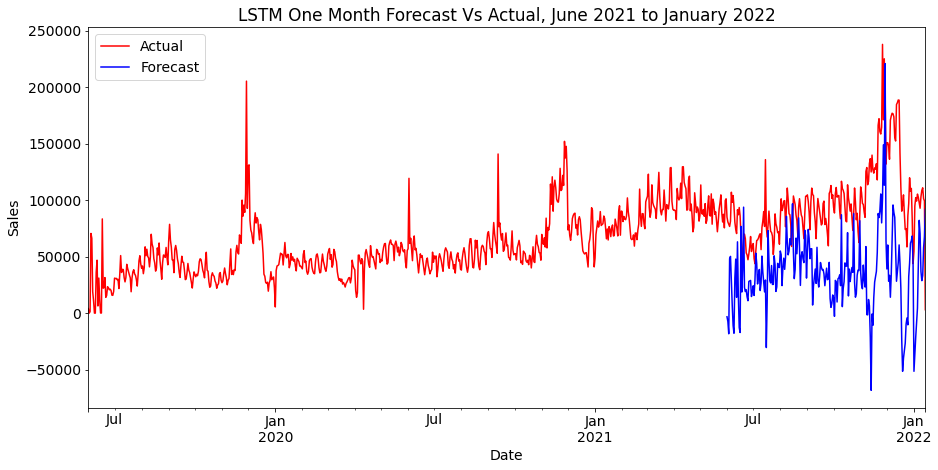

In [90]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)
daily_sales_pred.plot(x='date', y='net_revenue', color='r', label='Actual', ax=ax)
daily_sales_pred.plot(x='date', y='pred_value', color='b', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.title('LSTM One Month Forecast Vs Actual, June 2021 to January 2022')
plt.savefig('images/Forecast LSTM June-Jan.png')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, September 1 to 30, 2021')

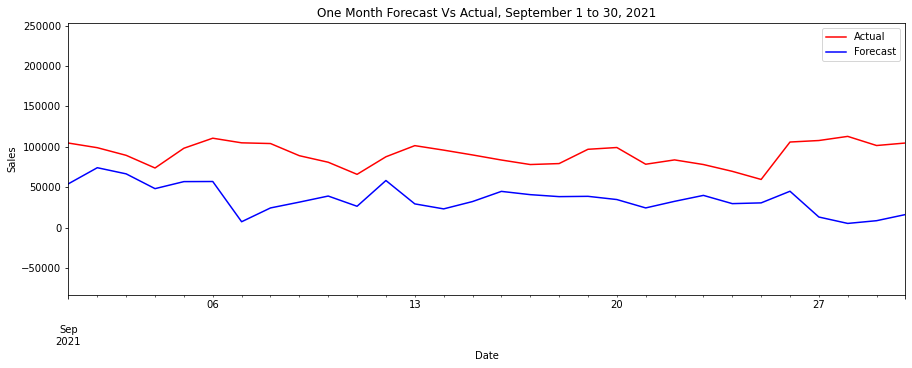

In [87]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
daily_sales_pred.plot(x='date', y='net_revenue', color='r', label='Actual', ax=ax)
daily_sales_pred.plot(x='date', y='pred_value', color='b', label='Forecast', ax=ax)
plt.legend()
ax.set_xbound(lower=dt.date(2021,9,1), upper=dt.date(2021,9,30))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('One Month Forecast Vs Actual, September 1 to 30, 2021')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, September 1 to 30, 2021')

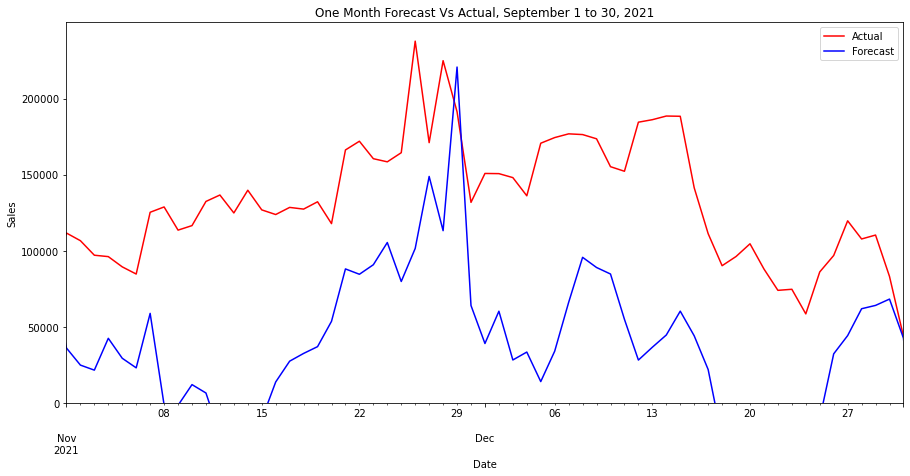

In [82]:
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)
daily_sales_pred.plot(x='date', y='net_revenue', color='r', label='Actual', ax=ax)
daily_sales_pred.plot(x='date', y='pred_value', color='b', label='Forecast', ax=ax)
plt.legend()
ax.set_xbound(lower=dt.date(2021,11,1), upper=dt.date(2021,12,31))
ax.set_ybound(lower=0, upper=249999)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('One Month Forecast Vs Actual, September 1 to 30, 2021')